In [1]:
from sklearn import model_selection, datasets, svm
from qiskit import QuantumCircuit, Aer, IBMQ, QuantumRegister, ClassicalRegister
import numpy as np
import qiskit
import copy
import matplotlib.pyplot as plt

In [2]:
iris=datasets.load_iris()

In [3]:
x=iris.data[:100]
x.shape

(100, 4)

In [4]:
y=iris.target[:100]
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [5]:
X_train, X_test, y_train, y_test= model_selection.train_test_split(x, y, test_size=0.2, random_state=42)

In [6]:
X_train.shape

(80, 4)

In [7]:
X_test.shape

(20, 4)

In [8]:
y_train

array([1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1])

In [9]:
y_test

array([1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0])

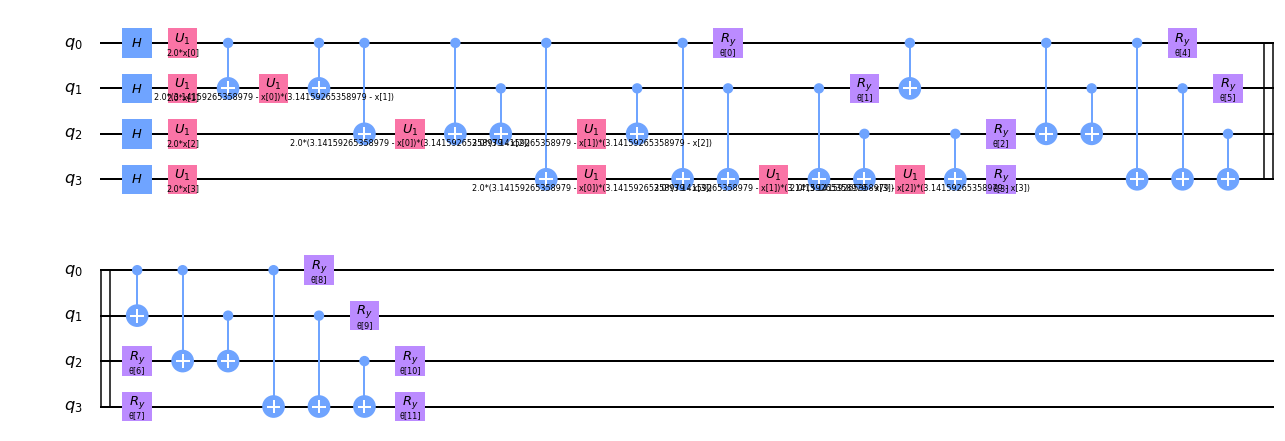

In [10]:
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
n=4
sv=Statevector.from_label('0'*n)
feature_map=ZZFeatureMap(n,reps=1)
var_form=RealAmplitudes(n,reps=2)
circuit=feature_map.combine(var_form)
circuit.draw(output='mpl')

In [11]:
def get_data_dic(params, x):
    parameter={}
    for i, p in enumerate(feature_map.ordered_parameters):
        parameter[p]=x[i]
    for i, p in enumerate(var_form.ordered_parameters):
        parameter[p]=params[i]
    return parameter

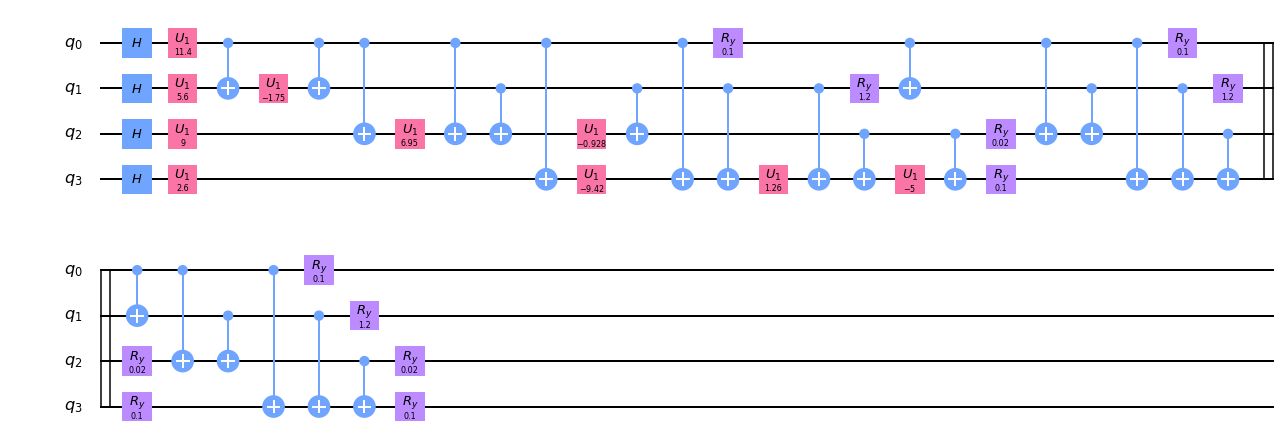

In [13]:
data=X_train[0]
params=np.array([0.1, 1.2, 0.02, 0.1, 0.1, 1.2, 0.02, 0.1, 0.1, 1.2, 0.02, 0.1, 0.1, 1.2, 0.02, 0.1])
circ_=circuit.assign_parameters(get_data_dic(params, data))
circ_.draw(output='mpl', plot_barriers=True)

In [14]:
feature_name=iris.feature_names[:100]
feature_name

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [15]:
target_name=iris.target_names
target_name

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [16]:
def assign_label(bit_string, target_name):
    hamming_weight=sum([int(k) for k in list(bit_string)])
    is_odd_parity=hamming_weight & 1
    if is_odd_parity:
        return target_name[1]
    else:
        return target_name[0]

In [17]:
def return_probabilities(counts, target_name):
    shots=sum(counts.values())
    result={target_name[0]:0, target_name[1]:0}
    for key,item in counts.items():
        label=assign_label(key,target_name)
        result[label] +=counts[key]/shots
    return result

In [18]:
return_probabilities({'00':10,'10':10}, target_name)

{'setosa': 0.5, 'versicolor': 0.5}

In [19]:
def classify(x_list, params, class_labels):
    qc_list=[]
    for x in x_list:
        circ_=circuit.assign_parameters(get_data_dic(params, x))
        qc=sv.evolve(circ_)
        qc_list +=[qc]
    probs=[]
    for qc in qc_list:
        counts=qc.to_counts()
        prob=return_probabilities(counts,class_labels)
        probs+=[prob]
    return probs

In [22]:
data=np.asarray([X_train[5]])
classify(data, params=np.array([0.1, 1.2, 0.02, 0.1, 0.1, 1.2, 0.02, 0.1, 0.1, 1.2, 0.02, 0.1, 0.1, 1.2, 0.02, 0.1]),class_labels=target_name)

<ipython-input-19-b72100197fcf>:9: DeprecationWarning: The `Statevector.to_counts` method is deprecated as of 0.13.0, and will be removed no earlier than 3 months after that release date. You should use the `Statevector.probabilities_dict` method instead.
  counts=qc.to_counts()


[{'setosa': 0.519171567792519, 'versicolor': 0.4808284322074807}]

In [23]:
def cost_estimate_sigmoid(probs, expected_label):
    p=probs.get(expected_label)
    sig=None
    if np.isclose(p,0.0):
        sig=1
    elif np.isclose(p,1.0):
        sig=0
    else:
        denominator=np.sqrt(2*p*(1-p))
        x=np.sqrt(200)*(0.5-p)/denominator
        sig=1/(1+np.exp(-x))
    return sig

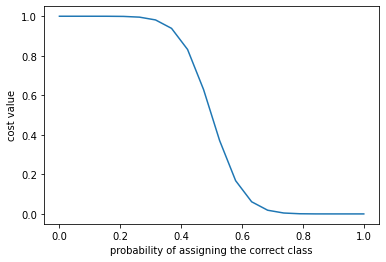

In [24]:
x=np.linspace(0,1,20)
y=[cost_estimate_sigmoid({'A':x_,'B':1-x_}, 'A') for x_ in x]
plt.plot(x,y)
plt.xlabel('probability of assigning the correct class')
plt.ylabel('cost value')
plt.show()

In [25]:
def cost_function(training_input, class_labels, params, shots=100, print_value=False):
    cost=0
    traning_samples=[]
    for sample in training_input:
        traning_samples.append(sample[0])
    
    training_labels=[]
    for label in training_input:
        training_labels.append(label[1])
    target_name=np.array([iris.target_names[p] for p in training_labels])
    training_labels=np.array(target_name)
    probs=classify(np.asarray(traning_samples),params,class_labels)
    for i, prob in enumerate(probs):
        cost += cost_estimate_sigmoid(prob,training_labels[i])
    cost /=len(traning_samples)
    
    if print_value:
        print('%.4f' % cost)
        
    return cost

In [26]:
data=zip(X_train, y_train)
my_list=list(data)

In [27]:
target_name=iris.target_names
target_name

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [28]:
np.array(target_name[0])

array('setosa', dtype='<U6')

In [29]:
cost_function(my_list,target_name,params)

<ipython-input-19-b72100197fcf>:9: DeprecationWarning: The `Statevector.to_counts` method is deprecated as of 0.13.0, and will be removed no earlier than 3 months after that release date. You should use the `Statevector.probabilities_dict` method instead.
  counts=qc.to_counts()


0.5759716268957283

In [39]:
from qiskit.aqua.components.optimizers import TNC
optimizer=TNC(maxiter=100)
objective_function= lambda params: cost_function(my_list, target_name, params, print_value=True)
np.random.seed(137)
init_params= 2*np.pi*np.random.rand(n*(1)*2*2)
opt_params, value, _ =optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
print()
print('opt_params', opt_params)
print('opt_value', value)

<ipython-input-19-b72100197fcf>:9: DeprecationWarning: The `Statevector.to_counts` method is deprecated as of 0.13.0, and will be removed no earlier than 3 months after that release date. You should use the `Statevector.probabilities_dict` method instead.
  counts=qc.to_counts()


0.4483
0.4483
0.4483
0.4483
0.4483
0.4483
0.4483
0.4483
0.4483
0.4483
0.4483
0.4483
0.4483
0.4483
0.4483
0.4483
0.4483
0.4483
0.4483
0.4483
0.4483
0.4483
0.4483
0.4483
0.4483
0.4483
0.4483
0.4483
0.4483
0.4483
0.4483
0.4483
0.4483
0.4483
0.5817
0.5817
0.5817
0.5817
0.5817
0.5817
0.5817
0.5817
0.5817
0.5817
0.5817
0.5817
0.5817
0.5817
0.5817
0.5817
0.5817
0.3783
0.3783
0.3783
0.3783
0.3783
0.3783
0.3783
0.3783
0.3783
0.3783
0.3783
0.3783
0.3783
0.3783
0.3783
0.3783
0.3783
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.2966
0.5390
0.5390
0.5390
0.5390
0.5390
0.5390
0.5390

0.1890
0.1890
0.1890
0.1890
0.1890
0.1890
0.1890
0.1890
0.1890
0.1890
0.1890
0.1890
0.1890
0.1890
0.1890
0.1890
0.1890
0.1890
0.1890
0.1890
0.1890
0.1890
0.1890
0.1890
0.1890
0.1890
0.1890
0.1890
0.1890
0.1890
0.1890
0.1890
0.1890
0.1890
0.1890
0.1890
0.3185
0.3185
0.3185
0.3185
0.3185
0.3185
0.3185
0.3185
0.3185
0.3185
0.3185
0.3185
0.3185
0.3185
0.3185
0.3185
0.3185
0.2171
0.2171
0.2171
0.2171
0.2171
0.2171
0.2171
0.2171
0.2171
0.2171
0.2171
0.2171
0.2171
0.2171
0.2171
0.2171
0.2171
0.1830
0.1830
0.1830
0.1830
0.1830
0.1830
0.1830
0.1830
0.1830
0.1830
0.1830
0.1830
0.1830
0.1830
0.1830
0.1830
0.1830
0.1810
0.1810
0.1810
0.1810
0.1810
0.1810
0.1810
0.1810
0.1810
0.1810
0.1810
0.1810
0.1810
0.1810
0.1810
0.1810
0.1810
0.1810
0.1810
0.1810
0.1810
0.1810
0.1810
0.1810
0.1810
0.1810
0.1810
0.1810
0.1810
0.1810
0.1810
0.1810
0.1810
0.1810
0.1805
0.1805
0.1805
0.1805
0.1805
0.1805
0.1805
0.1805
0.1805
0.1805
0.1805
0.1805
0.1805
0.1805
0.1805
0.1805
0.1805
0.1805
0.1805
0.1805
0.1805
0.1805

In [40]:
test_input=zip(X_test, y_test)
test_input=list(test_input)

In [41]:
test_input

[(array([6. , 2.7, 5.1, 1.6]), 1),
 (array([5.5, 2.3, 4. , 1.3]), 1),
 (array([5.9, 3.2, 4.8, 1.8]), 1),
 (array([4.8, 3. , 1.4, 0.3]), 0),
 (array([5.1, 3.8, 1.9, 0.4]), 0),
 (array([5.1, 3.4, 1.5, 0.2]), 0),
 (array([4.6, 3.6, 1. , 0.2]), 0),
 (array([5.5, 2.4, 3.8, 1.1]), 1),
 (array([5.4, 3.7, 1.5, 0.2]), 0),
 (array([5.1, 3.5, 1.4, 0.2]), 0),
 (array([5.7, 3.8, 1.7, 0.3]), 0),
 (array([4.8, 3.1, 1.6, 0.2]), 0),
 (array([6.1, 2.8, 4.7, 1.2]), 1),
 (array([5.5, 4.2, 1.4, 0.2]), 0),
 (array([5.5, 2.6, 4.4, 1.2]), 1),
 (array([5. , 3.6, 1.4, 0.2]), 0),
 (array([6.8, 2.8, 4.8, 1.4]), 1),
 (array([6.7, 3. , 5. , 1.7]), 1),
 (array([4.8, 3. , 1.4, 0.1]), 0),
 (array([5.4, 3.4, 1.5, 0.4]), 0)]

In [42]:
test_samples=[]
for sample in test_input:
    test_samples.append(sample[0])

    
test_labels=[]
for label in test_input:
    test_labels.append(label[1])
test_target_name=np.array([iris.target_names[p] for p in test_labels])
test_labels=list(test_target_name)

correct=0
for i, j in enumerate(test_samples):
    result=classify(np.asarray([j]), np.array(opt_params), target_name)
    print('---------------------------------------------')
    print('Data point:', j)
    print('Label:',test_labels[i])
    assigned_label=target_name[np.argmax([p for p in dict(result[0]).values()])]
    print('Assigned:', assigned_label)
    print('Probabilities', result)
    if test_labels[i] != assigned_label:
        print('Classification:', 'INCORRECT')
    else:
        print('Classification', 'CORRECT')
        correct+=1
num_misclassified=len(test_samples)-correct
print('*********************************************')
print('*********************************************')

correct_classification_percentage=100*(1-num_misclassified/len(test_samples))
print(correct_classification_percentage, '% of test data was correctly classified')

<ipython-input-19-b72100197fcf>:9: DeprecationWarning: The `Statevector.to_counts` method is deprecated as of 0.13.0, and will be removed no earlier than 3 months after that release date. You should use the `Statevector.probabilities_dict` method instead.
  counts=qc.to_counts()


---------------------------------------------
Data point: [6.  2.7 5.1 1.6]
Label: versicolor
Assigned: setosa
Probabilities [{'setosa': 0.5376462735906147, 'versicolor': 0.46235372640938516}]
Classification: INCORRECT
---------------------------------------------
Data point: [5.5 2.3 4.  1.3]
Label: versicolor
Assigned: versicolor
Probabilities [{'setosa': 0.35996015332575704, 'versicolor': 0.640039846674243}]
Classification CORRECT
---------------------------------------------
Data point: [5.9 3.2 4.8 1.8]
Label: versicolor
Assigned: versicolor
Probabilities [{'setosa': 0.4829870939815563, 'versicolor': 0.5170129060184436}]
Classification CORRECT
---------------------------------------------
Data point: [4.8 3.  1.4 0.3]
Label: setosa
Assigned: setosa
Probabilities [{'setosa': 0.676929161510275, 'versicolor': 0.32307083848972495}]
Classification CORRECT
---------------------------------------------
Data point: [5.1 3.8 1.9 0.4]
Label: setosa
Assigned: setosa
Probabilities [{'setosa':